In [2]:
import sys
!{sys.executable} -m pip install colossus
!{sys.executable} -m pip install emcee
!{sys.executable} -m pip install corner

In [3]:
import numpy as np
import scipy
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
from scipy.optimize import curve_fit

import emcee
import corner

mpl.rcParams['agg.path.chunksize'] = 10000  # This is required to correctly plot the mass function evaluated on the data array



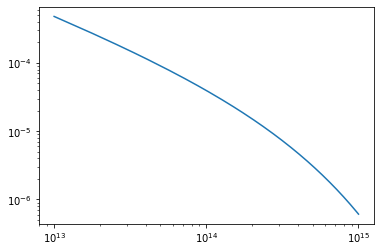

In [23]:

## cosmology.setCosmology('WMAP9') This is a default cosmology

params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.048254, 'sigma8': 0.81, 'ns': 0.96} # This sets a customized cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

# Array of masses
m_arr = np.linspace(1E13,1E15,128)

##for mass in m_arr:
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM') # q_out modifies the output function
##    mfunc_fof = mass_function.massFunction(mass, 0.0, mdef = 'fof', model = 'watson13', q_out = dndlnM))
plt.loglog(m_arr,  mfunc_so)


plt.show()   

In [24]:
a = np.load('converted_catalog_z0.000_mock0001.npz') # Import the catalog and read through it
print(a.files)
print(a['mass'].shape) # a['masss] is an array with 2772758 components
print(a['mass'].shape)
print(np.max(a['mass']))
print(len(a['mass']))
print(np.max(a['pos']))

print(np.log10(np.e))
BoxVolume = np.amax(a['pos'])**3.

print(BoxVolume)

['mass', 'pos']
(2772758,)
(2772758,)
5705458771838476.0
2772758
3869.9985
0.4342944819032518
57960537183.56983


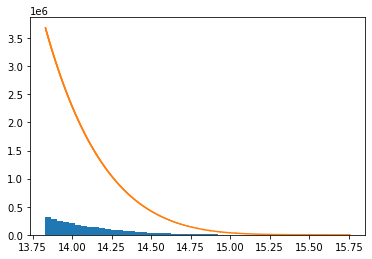

In [25]:
xmin = np.min(a['mass'])
xmax = np.max(a['mass'])
plt.hist(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ) , density = False )#Histogram of log-mass catalog, density=True gives a normalized histogram


m_arr = a['mass']
m_arr.sort() # order by increasing value
mfunc_so = mass_function.massFunction(m_arr, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')


plt.plot(np.log10(m_arr), BoxVolume*mfunc_so) 
plt.show()

0.037750056145860356
[59.68301956  0.32944042  0.8       ]


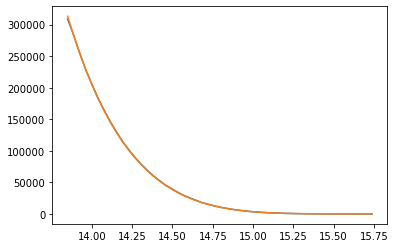

In [26]:
bin_heights, bin_borders = np.histogram(np.log10(a['mass']), bins=51, range = (np.log10(xmin), np.log10(xmax) ), density = False)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

size = bin_widths[0]
# Let us perform a preliminary fit
def func(x, a1, a2, a3):
    params = {'flat': True, 'H0': a1, 'Om0': a2, 'Ob0': 0.049,'sigma8': a3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume*size*(1./np.log10(np.e))*mass_function.massFunction(x, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so
print(size)

xdata = 10**(bin_centers)
ydata = bin_heights

popt, pcov = curve_fit(func, xdata, ydata, p0=[67., 0.3, 0.8], bounds=([50., 0.1, 0.1],[75, 0.8, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata), ydata)
plt.plot(np.log10(xdata), func(xdata, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

In [27]:
# Let us write the Likelihood function

def massfunction(theta, mass):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so = np.array(BoxVolume*size*(1./np.log10(np.e))*mass_function.massFunction(mass, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so

def log_prior(theta):
    Om0, sigma8 = theta
    if 0.1 < Om0 < 1.0 and 0.1 < sigma8 < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, mass, ydata):
    #err = DM_err What do I use as error array?
    mfunc_so = massfunction(theta, mass)
    logl = np.sum(ydata*np.log(mfunc_so)- mfunc_so)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl

def log_posterior(theta, mass, ydata):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(theta, mass, ydata)
    logpos = logl+lp
    return logpos


In [28]:
theta = [0.3,0.3]
print(log_likelihood(theta, xdata, ydata))
print(massfunction(theta, xdata))
 
      
theta = [0.1,0.3]
print(log_likelihood(theta, xdata, ydata))
print(massfunction(theta, xdata))

9033972.30778971
[6.34640595e+02 4.43869091e+02 3.06410857e+02 2.08626850e+02
 1.40000431e+02 9.25206062e+01 6.01635526e+01 3.84616717e+01
 2.41497470e+01 1.48782384e+01 8.98426699e+00 5.31147100e+00
 3.07061907e+00 1.73364811e+00 9.54617564e-01 5.11921235e-01
 2.66939872e-01 1.35128926e-01 6.62902031e-02 3.14563519e-02
 1.44099954e-02 6.35912143e-03 2.69729300e-03 1.09701091e-03
 4.26704223e-04 1.58301182e-04 5.58491572e-05 1.86797984e-05
 5.90345111e-06 1.75660241e-06 4.90256145e-07 1.27816760e-07
 3.09939454e-08 6.95770265e-09 1.43875456e-09 2.72594109e-10
 4.70506160e-11 7.35298241e-12 1.03358771e-12 1.29760826e-13
 1.44395342e-14 1.41264455e-15 1.20441437e-16 8.86524050e-18
 5.57669494e-19 2.96552804e-20 1.31756615e-21 4.82952307e-23
 1.44075779e-24 3.44721340e-26 6.51140943e-28]
-6429701.454534216
[2.15517060e+00 1.46901089e+00 9.92134670e-01 6.63724579e-01
 4.39685003e-01 2.88331396e-01 1.87108647e-01 1.20115045e-01
 7.62512995e-02 4.78500653e-02 2.96713078e-02 1.81739254e-02
 1

In [29]:
pos = [0.3,0.8] + 1e-2 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata, ydata))
sampler.run_mcmc(pos, 200, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [09:07<00:00,  2.74s/it]


State([[0.31006932 0.82480267]
 [0.30952053 0.82589449]
 [0.31056963 0.82423065]
 [0.31057393 0.82402659]
 [0.30992348 0.82554119]
 [0.31003944 0.82533002]
 [0.31023292 0.82423755]
 [0.31017615 0.82468071]
 [0.31025454 0.82475449]
 [0.30991    0.82561621]
 [0.30998265 0.82531526]
 [0.3100218  0.82518519]
 [0.31018972 0.82505074]
 [0.31058052 0.82443185]
 [0.30968896 0.82539618]
 [0.31034292 0.82472631]], log_prob=[30084551.39764806 30084550.6753181  30084549.87451287 30084549.9931091
 30084551.7104681  30084551.61486467 30084549.1354163  30084551.55163469
 30084551.58917353 30084551.48383693 30084552.03442537 30084552.08077279
 30084551.30048322 30084548.70386589 30084550.227794   30084550.90368513], blobs=None, random_state=('MT19937', array([1797721367, 3351653007, 3887787711, 3665436945, 2373254179,
       3424602644,  720874133, 2850072827,  702539917, 4032990301,
       3270037109, 1638686447, 1842392895, 2456242399, 1955163806,
       3990436710,  844562149, 2310136215,  58386167

(200, 16, 2)


Text(0.5, 0, 'step number')

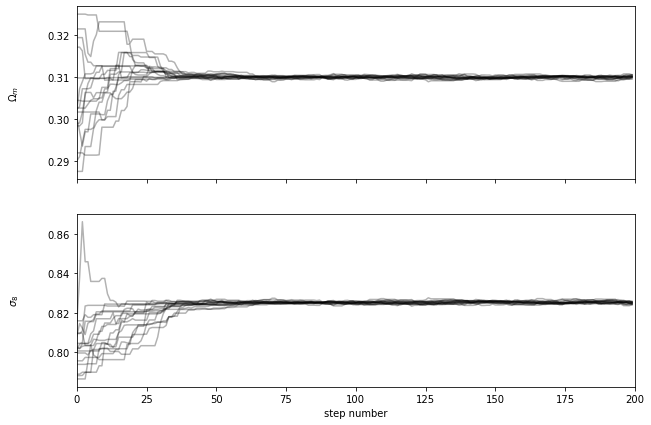

In [30]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["$\Omega_{m}$", "$\sigma_{8}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

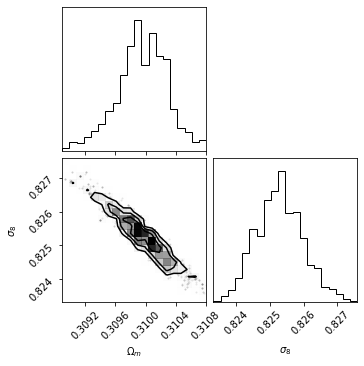

In [31]:
flat_samples = sampler.get_chain(discard=100, flat=True)

fig = corner.corner(flat_samples, labels=labels)

[60.03256952  0.32898307  0.8       ]


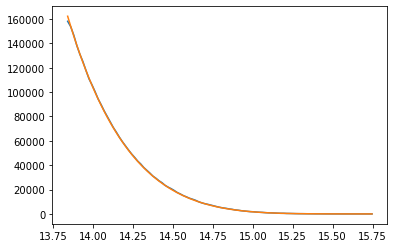

In [55]:
# Now we do the same fit for the other 4 catalogues
a1 = np.load('converted_catalog_z0.000_mock0001.npz') # Import the FIRST catalog and read through it
xmin1 = np.min(a1['mass'])
xmax1 = np.max(a1['mass'])
BoxVolume1 = np.amax(a1['pos'])**3.

bin_heights, bin_borders = np.histogram(np.log10(a1['mass']), bins=101, range = (np.log10(xmin1), np.log10(xmax1) ), density = False)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

size1 = bin_widths[0]
# Let us perform a preliminary fit
def func(x, c1, c2, c3):
    params = {'flat': True, 'H0': c1, 'Om0': c2, 'Ob0': 0.049,'sigma8': c3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume1*size1*(1./np.log10(np.e))*mass_function.massFunction(x, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata1 = 10**(bin_centers)
ydata1 = bin_heights

popt, pcov = curve_fit(func, xdata1, ydata1, p0=[ 67, 0.3, 0.8], bounds=([60, 0.1, 0.1],[70, 1., 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata1), ydata1)
plt.plot(np.log10(xdata1), func(xdata1, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

[60.01206483  0.3419102   0.8       ]


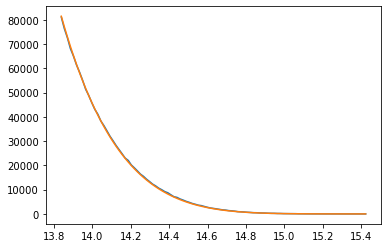

In [56]:
# Now we do the same fit for the other 4 catalogues
a2 = np.load('converted_catalog_z0.506_mock0001.npz') # Import the SECOND catalog and read through it
xmin2 = np.min(a2['mass'])
xmax2 = np.max(a2['mass'])
BoxVolume2 = np.amax(a2['pos'])**3.

bin_heights, bin_borders = np.histogram(np.log10(a2['mass']), bins=101, range = (np.log10(xmin2), np.log10(xmax2) ), density = False)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

size2 = bin_widths[0]
# Let us perform a preliminary fit
def func(x, c1, c2, c3):
    params = {'flat': True, 'H0': c1, 'Om0': c2, 'Ob0': 0.049,'sigma8': c3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume2*size2*(1./np.log10(np.e))*mass_function.massFunction(x, 0.506, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata2 = 10**(bin_centers)
ydata2 = bin_heights

popt, pcov = curve_fit(func, xdata2, ydata2, p0=[ 67, 0.3, 0.8], bounds=([60, 0.1, 0.1],[70, 1., 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata2), ydata2)
plt.plot(np.log10(xdata2), func(xdata2, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

[60.03500159  0.36116619  0.8       ]


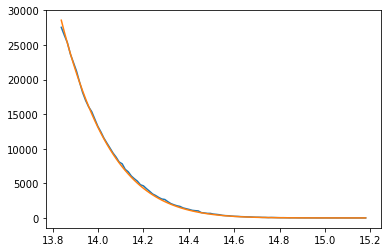

In [57]:
# Now we do the same fit for the other 4 catalogues
a3 = np.load('converted_catalog_z1.019_mock0001.npz') # Import the THIRD catalog and read through it
xmin3 = np.min(a3['mass'])
xmax3 = np.max(a3['mass'])
BoxVolume3 = np.amax(a3['pos'])**3.

bin_heights, bin_borders = np.histogram(np.log10(a3['mass']), bins=101, range = (np.log10(xmin3), np.log10(xmax3) ), density = False)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

size3 = bin_widths[0]
# Let us perform a preliminary fit
def func(x, c1, c2, c3):
    params = {'flat': True, 'H0': c1, 'Om0': c2, 'Ob0': 0.049,'sigma8': c3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume3*size3*(1./np.log10(np.e))*mass_function.massFunction(x, 1.019, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata3 = 10**(bin_centers)
ydata3 = bin_heights

popt, pcov = curve_fit(func, xdata3, ydata3, p0=[ 67, 0.3, 0.8], bounds=([60, 0.1, 0.1],[70, 0.8, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata3), ydata3)
plt.plot(np.log10(xdata3), func(xdata3, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

[60.01493266  0.38292117  0.8       ]


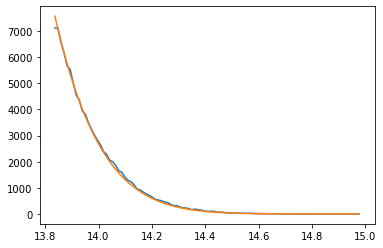

In [58]:
# Now we do the same fit for the other 4 catalogues
a4 = np.load('converted_catalog_z1.500_mock0001.npz') # Import the FOURTH catalog and read through it
xmin4 = np.min(a4['mass'])
xmax4 = np.max(a4['mass'])
BoxVolume4 = np.amax(a4['pos'])**3.

bin_heights, bin_borders = np.histogram(np.log10(a4['mass']), bins=101, range = (np.log10(xmin4), np.log10(xmax4) ), density = False)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

size4 = bin_widths[0]
# Let us perform a preliminary fit
def func(x, c1, c2, c3):
    params = {'flat': True, 'H0': c1, 'Om0': c2, 'Ob0': 0.049,'sigma8': c3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume4*size4*(1./np.log10(np.e))*mass_function.massFunction(x, 1.500, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata4 = 10**(bin_centers)
ydata4 = bin_heights

popt, pcov = curve_fit(func, xdata4, ydata4, p0=[ 67, 0.3, 0.8], bounds=([60, 0.1, 0.1],[70, 0.8, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata4), ydata4)
plt.plot(np.log10(xdata4), func(xdata4, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

[61.54301825  0.39888337  0.8       ]


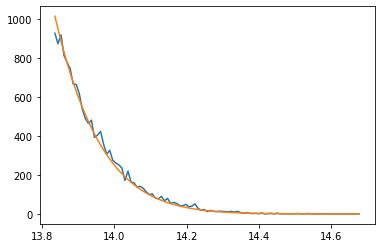

In [61]:
# Now we do the same fit for the other 4 catalogues
a5 = np.load('converted_catalog_z2.041_mock0001.npz') # Import the FIFTH catalog and read through it
xmin5 = np.min(a5['mass'])
xmax5 = np.max(a5['mass'])
BoxVolume5 = np.amax(a5['pos'])**3.

bin_heights, bin_borders = np.histogram(np.log10(a5['mass']), bins=101, range = (np.log10(xmin5), np.log10(xmax5) ), density = False)
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

size5 = bin_widths[0]
# Let us perform a preliminary fit
def func(x, c1, c2, c3):
    params = {'flat': True, 'H0': c1, 'Om0': c2, 'Ob0': 0.049,'sigma8': c3, 'ns': 0.95} # This sets a customized cosmology
    cosmology.addCosmology('myCosmofit', params)
    cosmo = cosmology.setCosmology('myCosmofit')
    mfunc_so = BoxVolume5*size5*(1./np.log10(np.e))*mass_function.massFunction(x, 2.041, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
    return mfunc_so


xdata5 = 10**(bin_centers)
ydata5 = bin_heights

popt, pcov = curve_fit(func, xdata5, ydata5, p0=[ 67, 0.3, 0.8], bounds=([60, 0.1, 0.1],[70, 0.8, 1.])) # Input params and bounds

print(popt) # Plot of estimated parameters (Terrible!)

plt.plot(np.log10(xdata5), ydata5)
plt.plot(np.log10(xdata5), func(xdata5, popt[0],popt[1], popt[2])) # Improvement needed, something starnge is happening
plt.show()

In [ ]:
xdata

In [62]:
def massfunction1(theta, mass1):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so1 = np.array(BoxVolume1*size1*(1./np.log10(np.e))*mass_function.massFunction(mass1, 0.0, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so1

def massfunction2(theta, mass2):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so2 = np.array(BoxVolume2*size2*(1./np.log10(np.e))*mass_function.massFunction(mass2, 0.506, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so2

def massfunction3(theta, mass3):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so3 = np.array(BoxVolume3*size3*(1./np.log10(np.e))*mass_function.massFunction(mass3, 1.019, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so3

def massfunction4(theta, mass4):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so4 = np.array(BoxVolume4*size4*(1./np.log10(np.e))*mass_function.massFunction(mass4, 1.500, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so4

def massfunction5(theta, mass5):
    Om0, sigma8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.048254,'sigma8': sigma8, 'ns': 0.96} # This sets a customized cosmology
    cosmo = cosmology.setCosmology('likeCosmo',params)
    mfunc_so5 = np.array(BoxVolume5*size5*(1./np.log10(np.e))*mass_function.massFunction(mass5, 2.041, mdef = 'vir', model = 'despali16', q_out = 'dndlnM'))
    return mfunc_so5

def log_prior(theta):
    Om0, sigma8 = theta
    if 0.1 < Om0 < 1.0 and 0.1 < sigma8 < 1.0:
        return 0.0
    return -np.inf

def log_likelihood1(theta, mass1, ydata1):
    #err = DM_err What do I use as error array?
    mfunc_so1 = massfunction1(theta, mass1)

    logl1 = np.sum(ydata1*np.log(mfunc_so1)- mfunc_so1)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl1

def log_likelihood2(theta, mass2, ydata2):
    #err = DM_err What do I use as error array?
    mfunc_so2 = massfunction2(theta, mass2)

    logl2 = np.sum(ydata2*np.log(mfunc_so2)- mfunc_so2)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl2

def log_likelihood3(theta, mass3, ydata3):
    #err = DM_err What do I use as error array?
    mfunc_so3 = massfunction3(theta, mass3)

    logl3 = np.sum(ydata3*np.log(mfunc_so3)- mfunc_so3)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl3

def log_likelihood4(theta, mass4, ydata4):
    #err = DM_err What do I use as error array?
    mfunc_so4 = massfunction4(theta, mass4)

    logl4 = np.sum(ydata4*np.log(mfunc_so4)- mfunc_so4)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl4

def log_likelihood5(theta, mass5, ydata5):
    #err = DM_err What do I use as error array?
    mfunc_so5 = massfunction1(theta, mass5)

    logl5 = np.sum(ydata5*np.log(mfunc_so5)- mfunc_so5)# - np.log(scipy.special.gamma(mfunc_so+1.)))
    return logl5


def log_posterior(theta, mass1, mass2, mass3, mass4, mass5, ydata1, ydata2, ydata3, ydata4, ydata5):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood1(theta, mass1, ydata1) + log_likelihood2(theta, mass2, ydata2) + log_likelihood3(theta, mass3, ydata3) + log_likelihood4(theta, mass4, ydata4) + log_likelihood5(theta, mass5, ydata5)
    logpos = logl+lp
    return logpos


In [63]:
pos = [0.3,0.8] + 1e-2 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata1, xdata2, xdata3, xdata4, xdata5, ydata1, ydata2, ydata3, ydata4, ydata5))
sampler.run_mcmc(pos, 200, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [09:40<00:00,  2.90s/it]


State([[0.13542491 0.99997718]
 [0.13529143 0.99999961]
 [0.13521993 0.99999178]
 [0.13567529 0.99997971]
 [0.13564645 0.99966923]
 [0.13524033 0.99998716]
 [0.13520932 0.99999472]
 [0.13565745 0.99996419]
 [0.13523068 0.99999455]
 [0.13527834 0.99999406]
 [0.13520495 0.99999368]
 [0.13565834 0.9999736 ]
 [0.1356452  0.99999273]
 [0.13527796 0.99999797]
 [0.13518355 0.99999095]
 [0.13525233 0.99999021]], log_prob=[41739471.21244232 41739485.1786598  41739481.59516811 41739429.52677834
 41739343.48797914 41739480.62486008 41739482.19203479 41739429.29230725
 41739482.89361255 41739483.65850706 41739481.6432143  41739431.84227058
 41739440.52330592 41739484.71600138 41739479.58798388 41739481.89704094], blobs=None, random_state=('MT19937', array([2090216747, 2413403098, 3662550742, 2572665696, 3733210120,
       1608134084,  931706423, 1452831590, 1560537582, 3505111113,
        144821823, 2671629360, 1601556649, 3417287256, 1811543495,
       3836081107,  437056816, 2619154159, 35556614

(200, 16, 2)


Text(0.5, 0, 'step number')

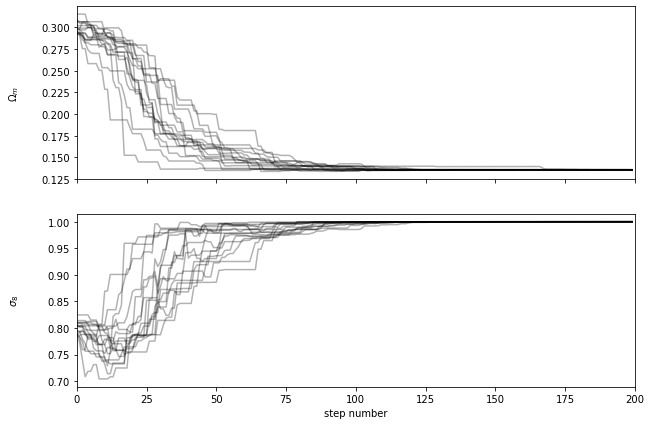

In [64]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["$\Omega_{m}$", "$\sigma_{8}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

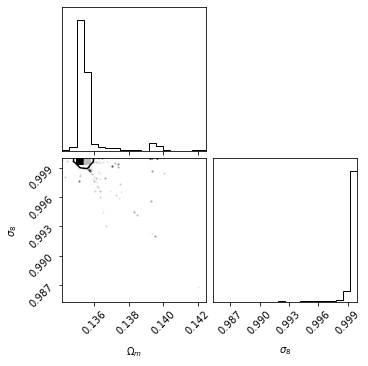

In [65]:
flat_samples = sampler.get_chain(discard=100, flat=True)

fig = corner.corner(flat_samples, labels=labels)